In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from numpy import log
from statsmodels.tsa.stattools import adfuller
from pmdarima.utils import c, diff
import matplotlib.pyplot as plt

In [71]:
bank = pd.read_csv(r'../data/final.csv', index_col='Date')
metrics = pd.read_csv(r'../data/metrics_time_series.csv', index_col='Date')
metrics.head()

,Adversity,DATE_QTR,REAL_GDP_GROWTH,NOMINAL_GDP_GROWTH,REAL_DISPOSABLE_INCOME_GROWTH,NOMINAL_DISPOSABLE_INCOME_GROWTH,UNEMPLOYMENT_RATE,CPI_INFLATION_RATE,THREE_MONTH_TREASURY_RATE,FIVE_YEAR_TREASURY_YIELD,...,EURO_AREA_BILATERAL_DOLLAR_EXCHANGE_RATE,DEVELOPING_ASIA_REAL_GDP_GROWTH,DEVELOPING_ASIA_INFLATION,DEV_ASIA_BILATERAL_DOLLAR_EXCHANGE_RATE,JAPAN_REAL_GDP_GROWTH,JAPAN_INFLATION,JAPAN_BILATERAL_DOLLAR_EXCHANGE_RATE,UK_REAL_GDP_GROWTH,UK_INFLATION,UK_BILATERAL_DOLLAR_EXCHANGE_RATE
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-31,Historical,Q1 2001,-1.1,1.3,3.7,6.5,4.2,3.9,4.8,4.9,...,0.879,4.8,1.7,106.1,2.1,0.7,125.5,5.8,0.1,1.419
2002-03-31,Historical,Q1 2002,3.5,4.9,9.3,10.1,5.7,1.3,1.7,4.5,...,0.872,7.8,0.5,107.4,0.7,-1.1,132.7,1.8,1.9,1.425
2003-03-31,Historical,Q1 2003,2.2,4.1,0.9,3.8,5.9,4.2,1.2,2.9,...,1.090,6.6,3.6,105.5,0.3,0.0,118.1,2.7,1.6,1.579
2004-03-31,Historical,Q1 2004,2.2,5.2,1.9,5.3,5.7,3.4,0.9,3.0,...,1.229,5.8,4.0,101.4,2.8,0.8,104.2,2.2,1.3,1.840
2005-03-31,Historical,Q1 2005,4.5,7.9,-4.6,-2.4,5.3,2.0,2.5,3.9,...,1.297,10.6,2.9,98.5,2.0,-1.2,107.2,3.4,2.5,1.889


In [72]:
len(metrics)

106

In [117]:
metrics.index = pd.to_datetime(metrics.index)
bank.index = pd.to_datetime(bank.index)
df = pd.DataFrame(bank.groupby('Date')['Balance'].sum(), columns=['Balance'])

In [119]:
df.head()

,Balance
Date,
2015-01-31,2.530386e+08
2015-02-28,2.504538e+08
2015-03-03,2.564281e+08
2015-03-31,2.513302e+08
2015-04-30,2.505905e+08


In [75]:
baseline = metrics[metrics['Adversity']=='Baseline']
adverse = metrics[metrics['Adversity']=='Adverse']

In [76]:
metrics = metrics.drop(columns=['Adversity','DATE_QTR'])
baseline = baseline.drop(columns=['Adversity','DATE_QTR'])
adverse = adverse.drop(columns=['Adversity','DATE_QTR'])

In [77]:
metrics = metrics[~metrics.index.duplicated(keep='first')]
baseline = baseline[~baseline.index.duplicated(keep='first')] #not necessary, defensive
adverse = adverse[~adverse.index.duplicated(keep='first')]

In [78]:
metrics = metrics.sort_index()
baseline = baseline.sort_index()
adverse = adverse.sort_index()

In [79]:
metrics = metrics.astype('float')
baseline = baseline.astype('float')
adverse = adverse.astype('float')

In [80]:
metrics = metrics.resample('M').mean().interpolate(method='linear')
baseline = baseline.resample('M').mean().interpolate(method='linear')
adverse = adverse.resample('M').mean().interpolate(method='linear')

In [81]:
metrics = metrics[metrics.index.isin(df.index)]

In [83]:
df = df.asfreq('M', method='ffill')

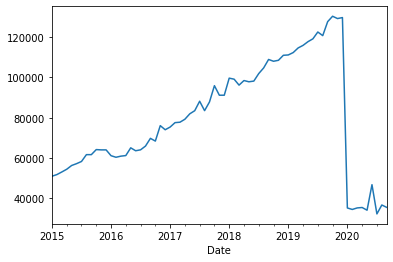

In [84]:
df.Balance.plot()

In [113]:
def generalized_forecast(data, exogenous, exogenous_forecast, num_log=0, test_size=0.3):
    '''
    
    '''

    if(type(num_log) != int):
        raise TypeError('Parameter num_log expects an integer.')
    
    if(num_log < 0):
        raise ValueError('Parameter num_log expects the natural numbers, no negative values.')
        
    if(test_size<0 or test_size>1 or type(test_size)!=float):
        raise TypeError('Please check test_size parameter. Must be a float between 0-1.')
    
    original_data = data.copy()

    
    if(num_log >0):
        for _ in range(num_log):
            data = log(data)
    
    #Dickey Fuller Test with data
    adf_result = adfuller(data, autolag='AIC')
    print('Results of Dickey Fuller')
    print('ADF Statistic: ', adf_result[0])
    print('p-value: ', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    suggested_n_adf = ndiffs(data, test='adf')
    print('Suggested Number of Differences: ', suggested_n_adf)
    
    if(suggested_n_adf!=0):
    
        #Return results with suggested number of differences
        data = diff(data, differences=suggested_n_adf)
        adf_result = adfuller(data, autolag='AIC')
        print()
        print('Results of Dickey Fuller with Suggested Differencing')
        print('ADF Statistic: ', adf_result[0])
        print('p-value: ', adf_result[1])
        print('Critical Values:')
        for key, value in adf_result[4].items():
            print('\t%s: %.3f' % (key, value))
        print('Suggested Number of Differences: ', ndiffs(data, test='adf'))
        print()
        print('Proceed analysis with suggested data? No: enter 0, Yes: enter 1.')
        proceed = input()
    
    if(proceed=='0'):
        print('Function killed.')
    
    elif(proceed=='1'):
        
        #Plot differenced data
        
        print()
        plt.subplots(figsize=(10,6))
        plt.plot(original_data)
        plt.title('Time Series')
        plt.xlabel('Year')
        plt.ylabel(original_data.columns[0])
        
        #Perform Train-test split
        
        original_data = pd.DataFrame(original_data)
        test_observations = int(len(original_data)*test_size)
        train_observations = len(original_data) - test_observations
        train_data = original_data.head(train_observations)
        train_data.index = original_data.head(train_observations).index
        train_exogenous = exogenous.head(train_observations)
        test_data = original_data.tail(test_observations)
        test_data.index = original_data.tail(test_observations).index
        test_exogenous = exogenous.tail(test_observations)
        
        
        #Use auto_arima
        
        auto_model = auto_arima(train_data, 
                                trace=True, 
                                exogenous=train_exogenous, 
                                error_action='ignore', 
                                suppress_warnings=True,
                                d=suggested_n_adf)
        
        auto_model.fit(train_data)
        point_forecasts, confidence_intervals = auto_model.predict(n_periods=len(test_data),
                                                                    exogenous=test_exogenous,
                                                                    return_conf_int=True,
                                                                    alpha=0.05)
        auto_forecast = pd.DataFrame({'Prediction':point_forecasts,
                             'Upper Bound':confidence_intervals[:,1],
                             'Lower Bound':confidence_intervals[:,0]},index = test_data.index)
        
        auto_forecast.index = test_data.index
        plt.subplots(figsize=(14,6))
        plt.title('Train-Test Split of Data')
        plt.plot(original_data.head(train_observations), color ='blue', label='Train')
        plt.plot(original_data.tail(test_observations), color= 'orange', label='Test')
        plt.plot(auto_forecast["Prediction"], color='purple', label='Prediction')
        plt.plot(auto_forecast["Upper Bound"], color='Pink', label='Upper Bound')
        plt.plot(auto_forecast["Lower Bound"], color='Pink', label='Lower Bound')
        plt.xlabel('Year')
        plt.ylabel(original_data.columns[0])
        plt.legend()
        
        #Now do actual forecast using auto_arima
        
        original_data = original_data[original_data.index.isin(exogenous.index)]        
        
        auto_model_forecast = auto_arima(original_data, 
                                trace=True, 
                                exogenous=exogenous, 
                                error_action='ignore', 
                                suppress_warnings=True,
                                d=suggested_n_adf)
        
        auto_model_forecast.fit(original_data)
        point_forecasts, confidence_intervals = auto_model_forecast.predict(n_periods=len(exogenous_forecast), 
                                                                           exogenous = exogenous_forecast,
                                                                          return_conf_int=True,
                                                                          alpha=0.05)
        auto_forecast = pd.DataFrame({'Prediction':point_forecasts,
                             'Upper Bound':confidence_intervals[:,1],
                             'Lower Bound':confidence_intervals[:,0]},index = exogenous_forecast.index)
        
        plt.subplots(figsize=(14,6))
        plt.title('Forecast of Data')
        plt.plot(original_data, color ='blue', label='Original Data')
        plt.plot(auto_forecast["Prediction"], color='purple', label='Prediction')
        plt.plot(auto_forecast["Upper Bound"], color='Pink', label='Upper Bound')
        plt.plot(auto_forecast["Lower Bound"], color='Pink', label='Lower Bound')
        plt.xlabel('Year')
        plt.ylabel(original_data.columns[0])
        plt.legend()
        
        
    else:
        print('Invalid input. Killed.')
        
        
        
        

Results of Dickey Fuller
ADF Statistic:  1.8658119686062966
p-value:  0.998470987879691
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Suggested Number of Differences:  2

Results of Dickey Fuller with Suggested Differencing
ADF Statistic:  -2.4403823383989054
p-value:  0.1306615692141775
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Suggested Number of Differences:  0

Proceed analysis with suggested data? No: enter 0, Yes: enter 1.
1

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1571.545, Time=1.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1694.595, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1565.796, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1565.829, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1567.812, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1567.794, Time=0.54 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1569.141, Time=0.60 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : A

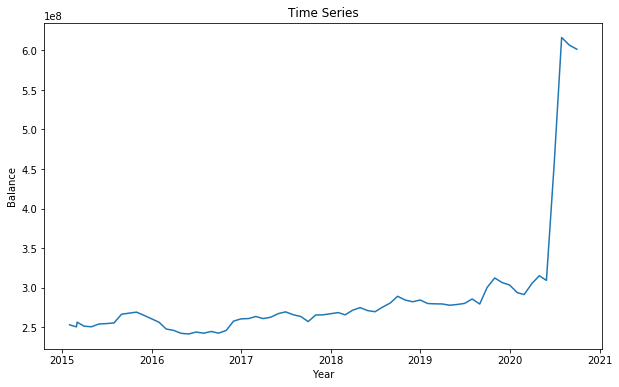

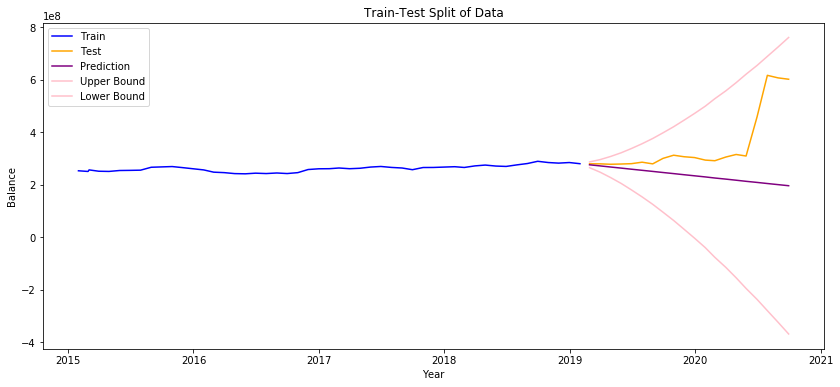

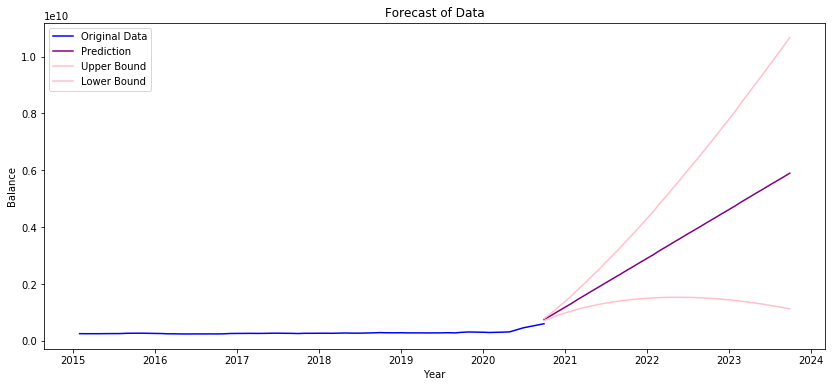

In [118]:
generalized_forecast(data=df, exogenous=metrics, exogenous_forecast=adverse, num_log=0, test_size=0.3)